The program is to focus on parallelizing KNN algorithm and examine its performance compared to the sequential implementation

# **1. Initial setup**

---



Install PyCuda library for multi-threading on GPU

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 471kB 64.1MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4535231 sha256=c1ce9327fe0038731d64d792d1d390855a27656dcdfeebea9ef7d8323c4154fd
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.1-py2.py3-none-any.whl size=59602 sha256=d52c43ce25f47fb1a92cb1775ccadbe5e29a881cdd6b6e1a195b2b1d707f5b7a
  Stored in directory: /root/.cache/pip/wheels/6f/da/1b/946775a88291378182ed92c9800d6d0ebc2a554cb89829cc24
  Created wheel for mako: filename=Mako-1.1.1-cp36-none-any.whl size=75410 sha256=82169f56077960829c801cc8525f2f0c03d48c343c695dd7647e35db2391ad2c
  Stored in directory: /root/.cache/pip/wheels/ff/50/a9/0ddeed8679a1fb65bf4677cb9c92701828b2c1821e22ef72fd
Successfully built pycuda pytools mako


In [3]:
from collections import Counter
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
# import pycuda.autoinit
# import pycuda.driver as drv
# from pycuda.compiler import SourceModule
from math import sqrt
import matplotlib.pyplot as plt

Load training and test data from .csv files

In [4]:
training_data = pd.read_csv('https://gitlab.com/duyvv/parallel-programming-project/raw/master/data/credit_train.csv')
test_data = pd.read_csv('https://gitlab.com/duyvv/parallel-programming-project/raw/master/data/credit_test.csv')

# **2. The sequential implementation of KNN algorithm**

---



The Euclidean distance between 2 vectors in space

In [5]:
def euclidean_distance(p, q):
    return np.sqrt(np.sum((p-q)**2))

KNN class

In [6]:
class KNN:

    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        valid = self.k <= len(X)
        if not valid:
            raise Exception('The value of k should be less than the size of training data')

    def predict(self, X):
        predicted_labels = [self._predict_element(x) for x in X]
        return predicted_labels

    def _predict_element(self, x):
        # compute distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # get k nearest samples, labels
        k_indices = np.argsort(distances)[0:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # majority vote, most common label
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        return most_common_label


In [7]:
def sequential_KNN(k, X_train, y_train, X_test, y_test):
  time_stamp1 = time.time()
  serial_kNN = KNN(k)
  serial_kNN.fit(X_train, y_train)
  predictions = serial_kNN.predict(X_test)
  accuracy = accuracy_score(y_test, predictions)
  # print('Accuracy = ' + str(accuracy))
  time_stamp2 = time.time()
  elapsed_time = time_stamp2 - time_stamp1
  # print('Serial Elapsed Time = ' + str(elapsed_time))
  return elapsed_time

# **2. The parallel implementation of KNN algorithm**

---

The implementation takes references from the link https://github.com/vinigracindo/pycudaDistances

Validate input data with scipy.sparse to check NaN/finite elements

In [8]:
from scipy import sparse

def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    if X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum()) \
      and not np.isfinite(X).all():
            raise ValueError("Array contains NaN or infinity.")

def assert_all_finite(X):
    """Throw a ValueError if X contains NaN or infinity.
    Input MUST be an np.ndarray instance or a scipy.sparse matrix."""
    # First try an O(n) time, O(1) space solution for the common case that
    # there everything is finite; fall back to O(n) space np.isfinite to
    # prevent false positives from overflow in sum method.
    _assert_all_finite(X.data if sparse.issparse(X) else X)

def safe_asarray(X, dtype=None, order=None):
    """Convert X to an array or sparse matrix.
    Prevents copying X when possible; sparse matrices are passed through."""
    if sparse.issparse(X):
        assert_all_finite(X.data)
    else:
        X = np.asarray(X, dtype, order)
        assert_all_finite(X)
    return X

Check pairwise property between arrays

In [9]:
def check_pairwise_arrays(X, Y, dtype=np.float32):
    """ Set X and Y appropriately and checks inputs
    If Y is None, it is set as a pointer to X (i.e. not a copy).
    If Y is given, this does not happen.
    All distance metrics should use this function first to assert that the
    given parameters are correct and safe to use.
    Specifically, this function first ensures that both X and Y are arrays,
    then checks that they are at least two dimensional while ensuring that
    their elements are floats. Finally, the function checks that the size
    of the second dimension of the two arrays is equal.
    Parameters
    ----------
    X : {array-like}, shape = [n_samples_a, n_features]
    Y : {array-like}, shape = [n_samples_b, n_features]
    Returns
    -------
    safe_X : {array-like}, shape = [n_samples_a, n_features]
        An array equal to X, guarenteed to be a numpy array.
    safe_Y : {array-like}, shape = [n_samples_b, n_features]
        An array equal to Y if Y was not None, guarenteed to be a numpy array.
        If Y was None, safe_Y will be a pointer to X.
    """
    if Y is X or Y is None:
        X = Y = safe_asarray(X, dtype=dtype)
    else:
        X = safe_asarray(X, dtype=dtype)
        Y = safe_asarray(Y, dtype=dtype)
    
    if len(X.shape) < 2:
        raise ValueError("X is required to be at least two dimensional.")
    if len(Y.shape) < 2:
        raise ValueError("Y is required to be at least two dimensional.")
    
    if X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))
    
    return X, Y

The main implementation for parallelization by multi-threading with PyCuda

In [10]:
# Only main Device
MAX_THREADS_PER_BLOCK = drv.Device(0).get_attribute(pycuda._driver.device_attribute.MAX_THREADS_PER_BLOCK)
print('Max threads per block = ' + str(MAX_THREADS_PER_BLOCK))
BLOCK_SIZE = int(sqrt(MAX_THREADS_PER_BLOCK))
print('Block size = ' + str(BLOCK_SIZE))

NameError: name 'drv' is not defined

In [ ]:
def euclidean_distances(X, Y):
    """
    Considering the rows of X (and Y=X) as vectors, compute the
    distance matrix between each pair of vectors.
    Parameters
    ----------
    X : {array-like}, shape = [n_samples_1, n_features]
    Y : {array-like}, shape = [n_samples_2, n_features]
    inverse: boolean, optional
        This routine will return the inverse Euclidean distances instead.
    Returns
    -------
    distances : {array}, shape = [n_samples_1, n_samples_2]
    Examples
    --------
    >>> from pycudadistances.distances import euclidean_distances
    >>> X = [[0, 1], [1, 1]]
    >>> # distance between rows of X
    >>> euclidean_distances(X, X)
    array([[ 0.,  1.],
           [ 1.,  0.]])
    >>> # get distance to origin
    >>> euclidean_distances(X, [[0, 0]])
    array([[ 1.        ],
           [ 1.41421356]])
    """
  
    X, Y = check_pairwise_arrays(X,Y)

    solution_rows = X.shape[0]
    solution_cols = Y.shape[0]
    solution = np.zeros((solution_rows, solution_cols))
    solution = solution.astype(np.float32)
    # print('Result size = ' + str(solution.shape))

    bdim = (BLOCK_SIZE, BLOCK_SIZE,1) # there are BLOCK_SIZE x BLOCK_SIZE threads in each block
    # print('Block size = ' + str(bdim))
    
    dx, mx = divmod(solution_cols, BLOCK_SIZE)
    dy, my = divmod(solution_rows, BLOCK_SIZE)
    gdim = ((dx + (mx>0)), (dy + (my>0))) # there is only 1 grid with (dx+1)x(dy+1) blocks
    # print('Grid size = ' + str(gdim))

    kernel_code_template = """
        #include <math.h>
        __global__ void euclidean(float *x, float *y, float *solution) {
            int idx = threadIdx.x + blockDim.x * blockIdx.x;
            int idy = threadIdx.y + blockDim.y * blockIdx.y;
            
            if ((idx < %(NCOLS)s) && (idy < %(NROWS)s)) {
                float result = 0.0;
                for(int iter = 0; iter < %(NDIM)s; iter++) {
                    float x_e = x[%(NDIM)s * idx + iter];
                    float y_e = y[%(NDIM)s * idy + iter];
                    result += pow((x_e - y_e), 2);
                }
                int pos = idy + %(NROWS)s * idx;
                solution[pos] = sqrt(result);
            }
        }
    """
    
    kernel_code = kernel_code_template % {
        'NCOLS': solution_rows,
        'NROWS': solution_cols,
        'NDIM': X.shape[1] # number of features/dimension of each element vector
    }

    module = SourceModule(kernel_code)
    func = module.get_function("euclidean")
    func(drv.In(X), drv.In(Y), drv.Out(solution), block=bdim, grid=gdim)
    
    return solution

Small test for the function

In [ ]:
X = np.array([[0,1], [3,4], [6,8]])
Y = np.array([[0,0], [0,1]])
result = euclidean_distances(X, Y)
print(result)
for column in range(result.shape[1]):
  print(result[:,column])

[[ 1.         0.       ]
 [ 5.         4.2426405]
 [10.         9.219544 ]]
[ 1.  5. 10.]
[0.        4.2426405 9.219544 ]


KNN parallel implementation

In [ ]:
def parallel_KNN(k, X_train, y_train, X_test, y_test):
  time_stamp1 = time.time()
  distance_matrix = euclidean_distances(X_train, X_test)
  prediction_labels = []
  for column in range(distance_matrix.shape[1]):
    distance_by_col = distance_matrix[:,column]
    k_indices = np.argsort(distance_by_col)[0:k]
    k_nearest_labels = [y_train[i] for i in k_indices]
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
    prediction_labels.append(most_common_label)
  accuracy = accuracy_score(y_test, prediction_labels)
  # print('Accuracy = ' + str(accuracy))
  time_stamp2 = time.time()
  elapsed_time = time_stamp2 - time_stamp1
  # print('Parallel Elapsed Time = ' + str(elapsed_time))
  return elapsed_time

# **3. Testing & Comparison**

---



**Case 1: Specifically k = 5 and different sizes of dataset**

In [ ]:
def load_data(data_records):
  # Extract a number of records according to testing cases
  X_train = training_data.iloc[:data_records,:(training_data.shape[1]-1)]
  y_train = training_data.iloc[:data_records,(training_data.shape[1]-1)]
  X_test = test_data.iloc[:500,:(test_data.shape[1]-1)]
  y_test = test_data.iloc[:500,(test_data.shape[1]-1)]  
  # transform into numpy array for faster computation
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  return X_train, y_train, X_test, y_test

In [ ]:
k = 5
data_records = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
                10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 
                100000, 200000, 227844]

In [ ]:
sequential_times = []
for record in data_records:
  X_train, y_train, X_test, y_test = load_data(record)
  t = sequential_KNN(k, X_train, y_train, X_test, y_test)
  sequential_times.append(t)

In [ ]:
parallel_times = []
for record in data_records:
  X_train, y_train, X_test, y_test = load_data(record)
  t = parallel_KNN(k, X_train, y_train, X_test, y_test)
  parallel_times.append(t)

In [ ]:
metrics = {'No. data records': data_records,
           'Sequential time': sequential_times,
           'Parallel time': parallel_times,
           'Speedup(k=5)': np.divide(sequential_times, parallel_times)}
metrics_table = pd.DataFrame(metrics)
metrics_table

,No. data records,Sequential time,Parallel time,Speedup(k=5)
0,1000,3.963131,0.423763,9.352244
1,2000,7.784708,0.414643,18.774480
2,3000,11.902612,0.443299,26.850060
3,4000,15.922956,0.420686,37.849956
4,5000,19.548037,0.433974,45.044256
5,6000,23.443722,0.448239,52.301798
6,7000,27.833237,0.472916,58.854549
7,8000,31.410983,0.472106,66.533720
8,9000,35.943944,0.481581,74.637309
9,10000,38.753696,0.492764,78.645514


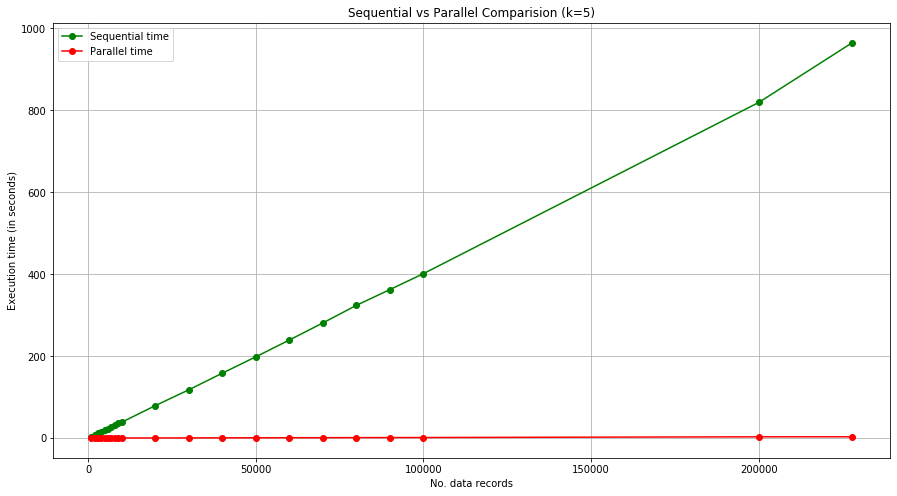

In [ ]:
plt.figure(figsize=(15,8))
plt.plot('No. data records', 'Sequential time', data=metrics_table, marker='o', color='g')
plt.plot('No. data records', 'Parallel time', data=metrics_table, marker='o', color='r')
plt.xlabel('No. data records')
plt.ylabel('Execution time (in seconds)')
plt.title('Sequential vs Parallel Comparision (k=5)')
plt.legend()
plt.grid()
plt.show()

**Case 2: Specifically 10000 data records and different k values**

In [ ]:
X_train, y_train, X_test, y_test = load_data(10000)
k_values = [(2*i+5) for i in range(10)]

In [ ]:
sequential_times = []
for k in k_values:
  t = sequential_KNN(k, X_train, y_train, X_test, y_test)
  sequential_times.append(t)

In [ ]:
parallel_times = []
for k in k_values:
  t = parallel_KNN(k, X_train, y_train, X_test, y_test)
  parallel_times.append(t)

In [ ]:
metrics = {'Value k': k_values,
           'Sequential time': sequential_times,
           'Parallel time': parallel_times,
           'Speedup(10000 records)': np.divide(sequential_times, parallel_times)}
metrics_table = pd.DataFrame(metrics)
metrics_table

,Value k,Sequential time,Parallel time,Speedup(10000 records)
0,5,42.572705,0.253872,167.693795
1,7,42.250031,0.233599,180.865858
2,9,41.796644,0.237161,176.237662
3,11,41.524069,0.231504,179.366559
4,13,41.447095,0.244783,169.321840
5,15,41.873855,0.231540,180.849548
6,17,41.192286,0.233414,176.477046
7,19,41.812162,0.234304,178.452653
8,21,41.231124,0.263423,156.520753
9,23,41.706358,0.289514,144.056532


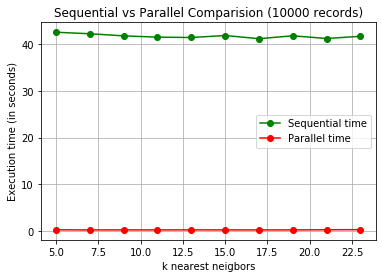

In [ ]:
# plt.figure(figsize=(15,8))
plt.plot('Value k', 'Sequential time', data=metrics_table, marker='o', color='g')
plt.plot('Value k', 'Parallel time', data=metrics_table, marker='o', color='r')
plt.xlabel('k nearest neigbors')
plt.ylabel('Execution time (in seconds)')
plt.title('Sequential vs Parallel Comparision (10000 records)')
plt.legend()
plt.grid()
plt.show()

# **GPU Configuration Specification**

---



In [ ]:
#GPU count and name
!nvidia-smi -L
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "L3 cache"
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fa49ce6a-421d-eb03-45da-104d51df1fa6)
Tue Feb 11 11:18:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |    518MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes